In [6]:
"""
AUTHOR: Shihao Zhang
Date: 10/24/2018

What is this script for?
This script can process raw data from ZenDesk by:
1. Train classifiers with labeled HVAC tickets
2. Classify tickets without label

How to use this script?
Prepare a excel file. Here is the preparation instruction:
1. 

Package required:
pandas, numpy, skilearn
"""

# Itâ€™s --> It's

'\nAUTHOR: Shihao Zhang\nDate: 10/24/2018\n\nWhat is this script for?\nThis script can process raw data from ZenDesk by:\n1. Train classifiers with labeled HVAC tickets\n2. Classify tickets without label\n\nHow to use this script?\nPrepare a excel file. Here is the preparation instruction:\n1. \n\nPackage required:\npandas, numpy, skilearn\n'

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
"""
USER INPUT
"""
path1="tickets(USWEST_2018Oct29).csv" 
path2="tickets(US_2018Oct29).csv"
path3="tickets(UK_2018Oct29).csv"
path4="tickets(AU_2018Oct29).csv"

path_train =  path3
cols_train = [ "Created","Description","Label","Requester_Name",'Assignee_Name']


In [8]:
table = {"air_flow1": 0,"cold_issue":1, "heat_issue":2,  "noise_issue":3, "unit_leaking1": 4}
table_reverse = {0: "air_flow1", 1: "cold_issue", 2: "heat_issue", 3: "noise_issue", 4: "unit_leaking1"}

In [9]:
pd.set_option('display.max_rows', 25)
#pd.set_option('max_colwidth',40)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
"""
Dataset Preparation
"""

if __name__ == "__main__":
    # CSV file should be in ASCII encoding
    data = pd.read_csv(path_train,usecols=cols_train)
    
Label_to_id = table
id_to_Label = table_reverse
data["Label_id"] = data["Label"].map(Label_to_id)

#Label_id_df = data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
#Label_to_id = dict(Label_id_df.values)
#id_to_Label = dict(Label_id_df[['Label_id', 'Label']].values)
data.head()

,Requester_Name,Assignee_Name,Created,Description,Label,Label_id
0,Daniel Jones,Erik Hal.,"10/30/2018, 1:09:00 AM","Heat up please. Again, very cold in here",cold_issue,1
1,Sarah OSullivan,WeWork Community team at 138 Holborn,"10/30/2018, 1:28:08 AM","Good morning, I'd like to put in a request to ...",cold_issue,1
2,Olga Albiero,Erik Hal.,"10/30/2018, 1:33:16 AM","Hello,\n\nit is me again. Could you please swi...",cold_issue,1
3,Matiss Kovalevskis,WeWork Community team at Iveagh Court,"10/30/2018, 1:34:16 AM","Hello Team,\n\nWould you please be so kind and...",cold_issue,1
4,Jo Kendall,WeWork Community team at 1 Primrose St,"10/30/2018, 1:35:21 AM",Hi Holly\nSo sorry to ask again but some of th...,cold_issue,1


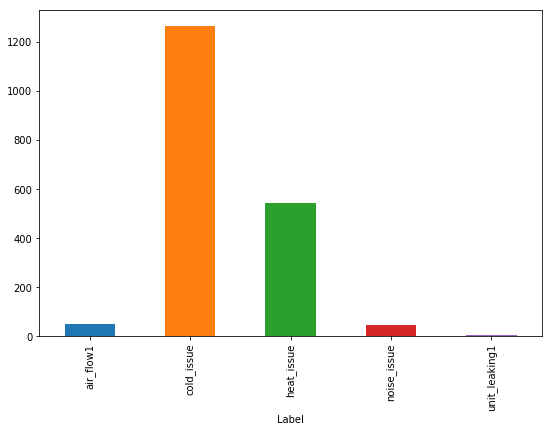

cold_issue       1265
heat_issue        544
air_flow1          50
noise_issue        46
unit_leaking1       7
Name: Label, dtype: int64


In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,6))
data.groupby('Label').Description.count().plot.bar(ylim=0)
plt.show()

print(data['Label'].value_counts())

In [13]:
data['Assignee_Name'].value_counts().head(25)

Erik Hal.                                             283
WeWork Community team at Aldgate Tower                137
WeWork Community team at 1 Primrose St                 96
WeWork Community team at 8 Devonshire Square           96
WeWork Community team at North West House              95
WeWork Community team at 138 Holborn                   91
WeWork Community team at 41 Corsham St                 89
WeWork Community team at Moor Place                    76
WeWork Community team at No 1 Poultry                  76
WeWork Community team at 16 Great Chapel St            73
WeWork Community team at 145 City Rd                   60
WeWork Community team at 12 Hammersmith Grove          59
WeWork Community team at Fox Court                     56
WeWork Community team at 33 Queen St                   55
WeWork Community team at 1 St Katharine&#x27;s Way     54
WeWork Community team at 15 Bishopsgate                47
WeWork Community team at The Cursitor                  47
WeWork Communi

In [271]:
"""
Feature Engineering
"""
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [272]:
# Keep AC

ac_keywords = [" AC ", " ac ", "a/c", "A/C", "HVAC", "Hvac", "hvac ", "Air Condition", "Air condition", "air condition"]

def keep_ac(texts,ac_keywords):
    data_description = []
    for text in texts:
        for keyword in ac_keywords:        
            if keyword in text: # actually acceptable
                text = text.replace(keyword," AC ")
        data_description.append(text)
    return data_description
            
data["Description"] = keep_ac(data["Description"], ac_keywords)

data["Description"][1]
    

TypeError: argument of type 'float' is not iterable

In [ ]:
# bag of words
def sent_to_words(texts):
    for text in texts:
        yield(simple_preprocess(text, min_len=2))

data_words = list(sent_to_words(data["Description"]))
print (data_words[3])


# Preparing Stop Words
stop_words = stopwords.words('english')
stop_words.extend(["hi","hey","guys","you","thank","thanks","please","would","could"])
for w in ["on","off","up","down"]:
    stop_words.remove(w)

# Define functions process stopwords & other keywords
def remove_stopwords(texts):
    new_texts=[]
    for text in texts:
        yield([word for word in text if word not in stop_words])

# Remove Stop Words
data_words_nonstops = list(remove_stopwords(data_words))
print(data_words_nonstops[3])

In [ ]:
# Trigram
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, string

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3),stop_words=stop_words)
features = tfidf.fit_transform(data["Description"]).toarray()
labels = data.Label

features.shape
print("Each of", features.shape[0], "consumer complaint narratives is represented by", features.shape[1], "features")
print("representing the tf-idf score for different unigrams and bigrams")

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Label, Label_id in sorted(Label_to_id.items()):
  features_chi2 = chi2(features, labels == Label)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))
  print("")

In [ ]:
"""
Model Buliding
"""


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  Model_Name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((Model_Name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model_Name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.subplots(figsize=(8,5))

sns.boxplot(x='Model_Name', y='accuracy', data=cv_df, width=0.8)
sns.stripplot(x='Model_Name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('Model_Name').accuracy.mean()

In [ ]:
label_list = ['air_flow1', 'cold_issue', 'heat_issue',  'noise_issue', 'unit_leaking1']

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_list, yticklabels=label_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_list, yticklabels=label_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, label_list))

In [ ]:
pd.set_option('max_colwidth',150)

from IPython.display import display, HTML
for predicted in label_list:
  for actual in label_list:
        if predicted == actual:
            print("{} predicted as {} : {} examples.".format(actual, predicted, conf_mat[table[actual], table[predicted]]))
            display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Description']])
            print()

In [ ]:
pd.set_option('max_colwidth',150)

from IPython.display import display, HTML
for predicted in label_list:
  for actual in label_list:
        if predicted != actual and conf_mat[table[actual], table[predicted]] >= 5:
            print("{} predicted as {} : {} examples.".format(actual, predicted, conf_mat[table[actual], table[predicted]]))
            display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Description']])
            print()